### 1/11/22
1. BackendV2 Factory and Hatlab Backend
2. Nonglobal ops transpiler layout pass
3. QFT Testbench

In [22]:
import numpy as np
from numpy import pi
from qiskit.visualization import plot_circuit_layout, plot_gate_map
from qiskit.transpiler.passes import BasisTranslator, ApplyLayout
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager

from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary,
)

from nonglobal_trivial_layout import NonGlobalTrivialLayout

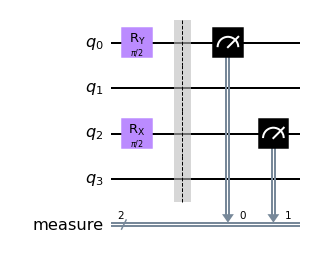

In [23]:
circ = QuantumCircuit(4)
circ.ry(np.pi/2, 0)
circ.rx(np.pi/2, 2)
circ.measure_active()
circ.draw(output='mpl')

In [24]:
from qiskit.test.mock.utils.configurable_backend_v2 import ConfigurableFakeBackendV2
from qiskit.circuit.library.standard_gates import (
    IGate,
    RXGate,
    RYGate,
    CZGate
)
class FakeExampleV2(ConfigurableFakeBackendV2):
    """A mock backendv2"""

    def __init__(self):
        qubits = list(range(4))
        coupling_map = [[0, 1], [0, 2], [0, 3], [1, 2]]
        qubit_coordinates = [[0, 1], [1, 0], [1, 1], [1, 2]]

        gate_configuration = {}
        gate_configuration[IGate] = [(i,) for i in qubits]

        # only can do RXGates on qubits 0 and 4
        gate_configuration[RXGate] = [
            (i,) for i in list(set(qubits).difference([1, 2]))
        ]
        # can do RY on all qubits
        gate_configuration[RYGate] = [(i,) for i in qubits]

        # can do CZ on all pairs in coupling map
        gate_configuration[CZGate] = [(i, j) for i, j in coupling_map]

        # can only measure qubits 0,3
        measurable_qubits = [0, 3]

        super().__init__(
            name="mock_example",
            description="a mock backend",
            n_qubits=len(qubits),
            gate_configuration=gate_configuration,
            parameterized_gates={RXGate: "theta", RYGate: "theta"},
            measurable_qubits=measurable_qubits,
            qubit_coordinates=qubit_coordinates,
        )

        #overwrite coupling map for plotting compatability
        self.plot_coupling_map = coupling_map

backend = FakeExampleV2()

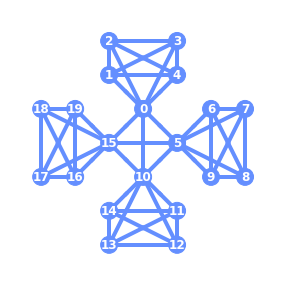

In [40]:
from mock_backend import LegacyFakeHatlab, FakeHatlab
hatlab_backend = LegacyFakeHatlab()
plot_gate_map(hatlab_backend, qubit_coordinates=hatlab_backend.qubit_coordinates)

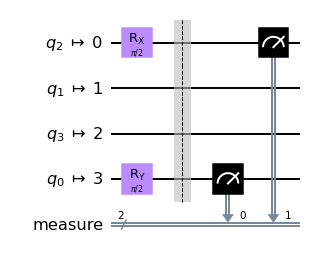

In [25]:
layout_analysis = NonGlobalTrivialLayout(backend.target)
apply_pass = ApplyLayout()
basis_pass = BasisTranslator(StandardEquivalenceLibrary, None, target=backend.target)
pm = PassManager([layout_analysis, apply_pass, basis_pass])
circ_trans = pm.run(circ)
circ_trans.draw(output='mpl')

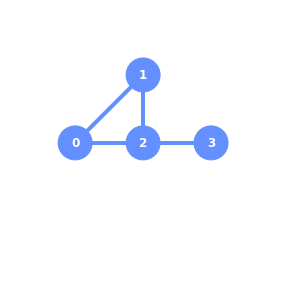

In [26]:
plot_gate_map(backend)

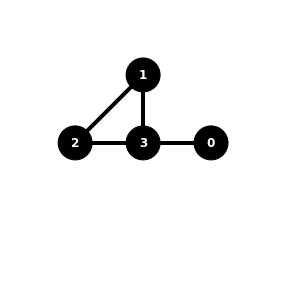

In [27]:
plot_circuit_layout(circ_trans, backend)

## Demonstrate that this was broken before my transpiler pass

In [28]:
pm = PassManager([basis_pass])
circ_trans = pm.run(circ)
circ_trans.draw(output='mpl')

TranspilerError: "Unable to map source basis {('measure', 1), ('rx', 1)} to target basis {'cz', 'id', 'ry', 'snapshot', 'reset', 'barrier'} over library <qiskit.circuit.equivalence.EquivalenceLibrary object at 0x7f5a9030ee50>."